# Refine Feature Groups into Final Bins

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [44]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned

In [3]:
fedges, grpid, zhist, zsim = load_groups('groups_16_120_200.npz')

In [5]:
init_data = load_binned('binned_40.npz')

In [17]:
# Need to include zedges in the load_groups result.
#assert len(zedges) % len(init_data[0]) == 0
#downsampling = len(zedges) // len(init_data[0])
downsampling = 3

In [27]:
def get_score(group_weights, gals_per_arcmin2=20., fsky=0.25, metric='FOM_DETF_3x2'):
    # Calculate the redshift distribution in each output bin.
    ngrp, nzbin = zhist.shape
    nbin = len(group_weights)
    assert group_weights.shape[1] == ngrp
    zhist_out = group_weights.dot(zhist)
    # Downsample to the redshift binning used for fast reweighted scores.
    zhist_ds =  zhist_out.reshape(nbin, nzbin // downsampling,  downsampling).sum(axis=-1)
    # Calculate the corresponding weights to use.
    w = zhist_ds / zhist.sum()
    # Calculate the metrics for these weights.
    weights = jnp.array([w,  w])
    scores = reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2=gals_per_arcmin2, fsky=fsky, metrics=[metric])
    return scores[metric]

## Method 1

Keep the groups in their mean-redshift sorted order and find the breakpoints with the maximum score using an exhaustive search:

In [40]:
def method1_weights(*breaks):

    ngrp, nzbin = zhist.shape
    nbin = len(breaks) + 1
    w = np.zeros((nbin, ngrp))
    breaks = np.concatenate(([0], breaks, [ngrp]))
    assert np.all(np.diff(breaks) > 0)
    igrp = np.arange(ngrp)
    for i in range(nbin):
        sel = (breaks[i] <= igrp) & (igrp < breaks[i + 1])
        w[i, sel] = 1.
    return w

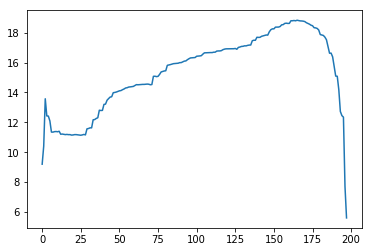

Best breaks are [166] with score = 18.843883514404297.


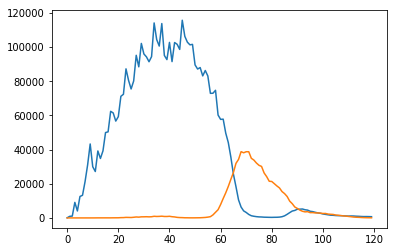

In [45]:
def method1_optimize(nbin=2):
    scores = []
    breaks = []
    ngrp, nzbin = zhist.shape
    for i1 in range(1, ngrp - 1):
        breaks.append([i1])
        w = method1_weights(*breaks[-1])
        scores.append(float(get_score(w)))
    plt.plot(scores)
    plt.show()
    ibest = np.argmax(scores)
    print(f'Best breaks are {breaks[ibest]} with score = {scores[ibest]}.')
    wbest =  method1_weights(*breaks[ibest])
    #zc = 0.5 * (zedges[1:] + zedges[:-1])
    dndz =  wbest.dot(zhist)
    for i in range(nbin):
        #plt.plot(zc, dndz[i])
        plt.plot(dndz[i])

method1_optimize()